# In Google Colabo, go to  **"Change runtime type"** and choose **"T4 GPU"** !!

In [1]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/flt_tokyo_region_wind_speed_hourly.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

#standardization (but we do not need it here, since standardized original data is filtered)

# mean_value = np.mean(data)
# std_dev    = np.std(data)
# data       = (data - mean_value) / std_dev


data = data.T

Mounted at /content/drive


In [2]:
# @title Loading optuna and libraries
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import networkx as nx
import csv
import datetime

!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.0 MB/s eta 0:00:00


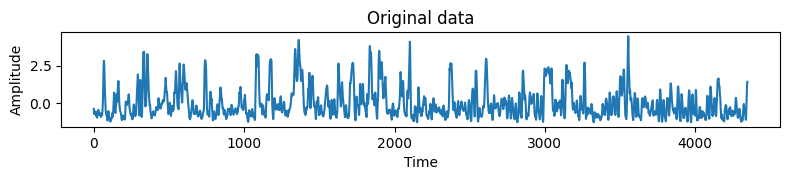

Data shape: (42, 4347)


In [3]:
# @title Visualization

plt.figure(figsize=(8, 3))
plt.subplot(2, 1, 1)
plt.plot(data[0,:])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

print('Data shape:',data.shape)

In [4]:
# @title Definition of Reservoir computing (without ``Class" setting!!)

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

# Separate integer and decimal portions
    seed_int_low  = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction      = seed_value - seed_int_low

# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

#Specify non-zero positions
def generate_random_binary_matrix(N_x, N_y, density, seed_value_binary):

    num_ones = int(N_x*N_y * density)
    matrix   = np.zeros(N_x*N_y, dtype=int)
    np.random.seed(seed_value_binary)
    ones_indices = np.random.choice(N_x*N_y, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, N_y))


def recurrent_matrix(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W


#############################
# reservoir state vector
#############################

def Reservoir_batch(x_in, x, W, alpha, bias_scale):
    M, N_x = x.shape
    Wbias = np.ones((M, N_x)) * bias_scale
    x = (1.0 - alpha) * x + alpha * np.tanh(x @ W.T + Wbias + x_in)
    return x

############################
#Ridge Regression and  Output Weight Matrix
############################

# We employ the excellent Ohkubo-Inubushi method here
#See Scientific Reports volume 14, Article number: 30918 (2024)

def quadratic_expand(x):
    x = np.asarray(x)
    if x.ndim == 1:
        x = x.reshape(1, -1)   # 1 sample case
    n_samples, n_features = x.shape

    # Obtain indices of the upper triangle (i<=j)
    i, j = np.triu_indices(n_features)

    #Generate quadratic terms for all samples at once -> shape (n_samples, n_pairs)
    s = x[:, i] * x[:, j]

    # Join along the column axis (axis=1) -> shape (n_samples, n_features + n_pairs)
    x_quad = np.concatenate([x, s], axis=1)
    return x_quad


def Ridge_batch(d, x, X_XT, D_XT):
    """
    x: (M, N_x)
    d: (M, N_y)
    X_XT: (N_x, N_x)
    D_XT: (N_y, N_x)
    """

    x_quad = quadratic_expand(x)

    X_XT += x_quad.T @ x_quad  # (N_x, M) @ (M, N_x) -> (N_x, N_x)
    D_XT += d.T @ x_quad       # (N_y, M) @ (M, N_x) -> (N_y, N_x)
    return X_XT, D_XT


def get_Wout_opt(X_XT,D_XT,N_x,beta):

        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(X_XT.shape[0])).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x, T_train,Win,W,N_x,dim,alpha,discard_len,bias_scale):

    # Calculate the size of the expanded state vector
    expanded_size = N_x + int(N_x * (N_x + 1) / 2)

    X_XT          = np.zeros((expanded_size, expanded_size))
    D_XT          = np.zeros((dim, expanded_size))
    x_special_vec = np.zeros((train_U.shape[0],N_x))
    x             = np.zeros((train_U.shape[0], N_x))  # (M, N_x)

    for n in range(T_train):
        # Input (batched)
        u = train_U[:, n, :]                   # (M, input_dim)

        # Reservoir induction (batch)
        x_in = u @ Win.T                       # (M, N_x)
        x = Reservoir_batch(x_in, x, W, alpha, bias_scale)

        # teacher data
        d = train_D[:, n, :]                   # (M, output_dim)

        if n > discard_len:                    # discard the first part
            X_XT, D_XT = Ridge_batch(d, x, X_XT, D_XT)

    # the last Reservoir vectors
    x_special_vec = x  # (M, N_x)

    return X_XT, D_XT, x_special_vec

########################
#induction formula for creating estimated data
########################

def run_batch(test_U, x, Win, W, Wout, alpha, T_test, bias_scale):
    """
    test_U : (M, input_dim)
    x      : (M, N_x): reservoir state
    Win    : (N_x, input_dim)
    W      : (N_x, N_x)
    Wout   : (output_dim, N_x)
    """

    y = test_U
    Y_pred = []

    for n in range(T_test):
        # Reservoir induction（batched）
        x_in = y @ Win.T
        x = Reservoir_batch(x_in, x, W, alpha, bias_scale)

        # Output
        x_quad = quadratic_expand(x)
        y_pred = x_quad @ Wout.T
        Y_pred.append(y_pred)
        y = y_pred

    # Prediction to NumPy array
    Y_pred = np.stack(Y_pred, axis=1)  # (M, T_test, output_dim)

    return Y_pred

In [5]:
# @title Definition of implementation of train and test

def impl_train_test(T_train,data,dim,N_x,seed_value,input_scale,density, \
                    rho,T_0,lag,alpha,discard_len,bias_scale,beta,T_test):



#Initialization of estimated data

    data_delay_train = np.zeros((data.shape[0],T_train+1,dim), dtype=float)
    test_Y           = np.zeros((data.shape[0],T_test,dim,test_num))
    test_D           = np.zeros((data.shape[0],T_test,dim,test_num))
#Fix input and recurrent weight matrices

    Win= input_matrix(N_x,seed_value,input_scale,dim)
    W = recurrent_matrix(N_x, density, rho,seed_value)

##########################################
#Convert training data to a delay coordinate system

    for i in range(dim):

        data_delay_train[:,:,i] = data[:,T_0-T_train-i*lag:T_0-i*lag+1] # i*lag Step-delayed time series


# Initialization of training data

    train_U = np.zeros((data.shape[0],T_train,dim), dtype=float)
    train_D = np.zeros((data.shape[0],T_train,dim), dtype=float)

#Input/output of training data

    train_U = data_delay_train[:,:T_train,:]
    train_D = data_delay_train[:,1:T_train+1,:]

##The last time data of the training data output must overlap with the test data,
##since non-increment online learning!

#Ridge

    X_XT, D_XT,_ = train(train_U,train_D,np.zeros(N_x),T_train, \
                                  Win, W, N_x, dim, alpha,discard_len,bias_scale)

# Generate regression weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

#######################
# Model selection phase
    data_delay_test         = np.zeros((data.shape[0],T_test+1,dim,test_num), dtype=float)
    tentative_test_Y        = np.zeros((T_test,dim,test_num))
    data_delay_train_resvec = np.zeros((data.shape[0],T_train+1,dim,test_num), dtype=float)

#Convert training data to a delay coordinate system (to create reservoir state vec)

    for t in range(test_num):

        for i in range(dim):

            data_delay_train_resvec[:,:,i,t] = data[:,T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series

    # Initialization of training data

        train_U = np.zeros((data.shape[0],T_train,dim), dtype=float)
        train_D = np.zeros((data.shape[0],T_train,dim), dtype=float)

    #Input/output of training data

        train_U[:,:,:] = data_delay_train_resvec[:,:T_train,:,t]
        train_D[:,:,:] = data_delay_train_resvec[:,1:T_train+1,:,t]

    ##The last time data of the training data output must overlap with the test data!

    #Ridge

        _, _,x_special_vec = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)


##############################
#test in model selection phase

        for i in range(dim):

            data_delay_test[:,:,i,t] = data[:,T_0-i*lag+t:
                                            T_0+T_test-i*lag+t+1] # i*lag step delayed time series

#Generate estimated data

            test_Y[:,:,:,t] = run_batch(data_delay_test[:,0,:,t],x_special_vec[:,:], \
                                         Win,W,Wout,alpha,T_test,bias_scale)
            test_D[:,:,:,t] = data_delay_test[:,1:T_test+1,:,t]

    return np.abs(test_Y[:,T_test-1,0,:]-test_D[:,T_test-1,0,:]), test_Y, test_D


In [6]:
# @title Setting of Optuna study

study_without_save = optuna.create_study(direction="minimize")

storage = "sqlite:////content/drive/My Drive/Colab Notebooks/reservoir_quadoutput_trials.db"
study_with_save = optuna.create_study(study_name="Parallel_Reservoir_QuadOutput",direction="minimize",storage=storage,load_if_exists=True)

[I 2025-09-28 05:10:50,553] A new study created in memory with name: no-name-5f429448-e006-4ae6-9885-5581af2089d0
[I 2025-09-28 05:10:55,334] Using an existing study with name 'Parallel_Reservoir_QuadOutput' instead of creating a new one.


In [7]:
# @title Hyperparameters

T_train                = 1000  # Training period
T_test                 = 3   # Forecast period (in the model selection phase)
T_test_general_perform = 3   # Forecast period for generalizaiton performance (model evaluation phase)

discard_len  = 10    # Number of steps not learned at the beginning (not important)

max_lag    = 1    # Maximum of lag for delay coordinate
max_dim    = 4    # Maximum of dimension for delay coordinate
test_num   = 1    # test numbers for each time series

#####################################################
#Hyperparameters: Bayesian optimization for Reservoir

Node      = 30   # Reservoir Node
n_trials  = 50   # Number of times to test with optuna (generate MAE for this number of times)

study = study_without_save # choose ``study_without_save" or ``study_with_save""

In [8]:
# @title Implementation of Bayesian optimization of Reservoir

%%time

def objective(trial):
    lag         = trial.suggest_int("lag", max_lag, max_lag)
    dim         = trial.suggest_int("dim", max_dim, max_dim)
    N_x         = trial.suggest_int("N_x", Node, Node)                #fixed here
    beta        = trial.suggest_float("beta", 0.0001, 0.0001)
    density     = trial.suggest_float("density", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.5)
    rho         = trial.suggest_float("rho", 0, 1.5)
    alpha       = trial.suggest_float("alpha", 0, 1)
    seed_value  = trial.suggest_float("seed_value", 0, 100)
    bias_scale  = trial.suggest_float("bias_scale", -1.5, 1.5)

    #Test start time (model selection phase)

    T_0 = T_train + lag * (dim-1)

    #Implementation of train-test

    mae,_,_ = impl_train_test(T_train,data,dim,N_x,seed_value,input_scale,density, \
                    rho,T_0,lag,alpha,discard_len,bias_scale,beta,T_test)

    return np.mean(mae)

######################
# Perform optimization

study.optimize(objective, n_trials)

# Display of optimization results
print("Best trial:")
trial = study.best_trial
print(f"  'params': {trial.params},")
print(f"  'value': {trial.value},")

[I 2025-09-28 05:11:10,805] Trial 0 finished with value: 0.312293627512214 and parameters: {'lag': 1, 'dim': 4, 'N_x': 30, 'beta': 0.0001, 'density': 0.7813116987883957, 'input_scale': 0.9777389702313559, 'rho': 0.2835352865028381, 'alpha': 0.2501747029672966, 'seed_value': 66.22613348001305, 'bias_scale': 0.5799597677354811}. Best is trial 0 with value: 0.312293627512214.
[I 2025-09-28 05:11:25,086] Trial 1 finished with value: 0.2879383411756618 and parameters: {'lag': 1, 'dim': 4, 'N_x': 30, 'beta': 0.0001, 'density': 0.940917437498619, 'input_scale': 1.4067661175464325, 'rho': 1.2044914323448621, 'alpha': 0.6303292840609342, 'seed_value': 87.04259964731187, 'bias_scale': 1.4089464165820513}. Best is trial 1 with value: 0.2879383411756618.
[I 2025-09-28 05:11:28,662] Trial 2 finished with value: 0.31243388371877334 and parameters: {'lag': 1, 'dim': 4, 'N_x': 30, 'beta': 0.0001, 'density': 0.6811698037343168, 'input_scale': 0.6266643576129808, 'rho': 0.1913378086812662, 'alpha': 0.26

Best trial:
  'params': {'lag': 1, 'dim': 4, 'N_x': 30, 'beta': 0.0001, 'density': 0.3058579683743379, 'input_scale': 0.21221362323420317, 'rho': 0.4927290748771086, 'alpha': 0.04964070550453914, 'seed_value': 53.73384826373873, 'bias_scale': 0.6400991469128963},
  'value': 0.25907094681591175,
CPU times: user 6min 34s, sys: 1.3 s, total: 6min 35s
Wall time: 4min 10s


In [9]:
# @title Best hyperparameters

best_params = study.best_params

lag          = best_params["lag"]
dim          = best_params["dim"]
N_x          = best_params["N_x"]
beta         = best_params["beta"]
density      = best_params["density"]
input_scale  = best_params["input_scale"]
rho          = best_params["rho"]
alpha        = best_params["alpha"]
seed_value   = best_params["seed_value"]
bias_scale   = best_params["bias_scale"]

print(f"max_lag= {max_lag}")
print(f"max_dim= {max_dim}")
print(f"lag= {lag}")
print(f"dim= {dim}")
print(f"N_x= {N_x}")
print(f"beta= {beta}")
print(f"density= {density}")
print(f"input_scale= {input_scale}")
print(f"rho= {rho}")
print(f"alpha= {alpha}")
print(f"seed_value= {seed_value}")
print(f"bias_scale= {bias_scale}")


max_lag= 1
max_dim= 4
lag= 1
dim= 4
N_x= 30
beta= 0.0001
density= 0.3058579683743379
input_scale= 0.21221362323420317
rho= 0.4927290748771086
alpha= 0.04964070550453914
seed_value= 53.73384826373873
bias_scale= 0.6400991469128963


In [10]:
# @title Training in Model Evaluation phease

%%time

#Test start time (model evaluation phase)
#NOT T_0 = T_train+lag*(dim-1)!!

T_0 = T_train+lag*(dim-1)+T_test+test_num-1

mae,test_Y,test_D = impl_train_test(T_train,data,dim,N_x,seed_value,input_scale,density, \
                    rho,T_0,lag,alpha,discard_len,bias_scale,beta,T_test_general_perform)

mae_mean = np.mean(mae)

CPU times: user 6.98 s, sys: 22.9 ms, total: 7.01 s
Wall time: 3.67 s


MAE mean: 0.18282437592687698
forecast period for general-perform: 3


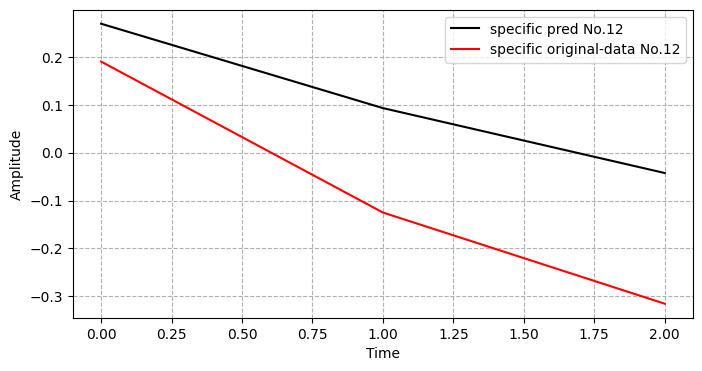

CPU times: user 272 ms, sys: 4.95 ms, total: 277 ms
Wall time: 182 ms


In [11]:
# @title Implementation of Model Evaluation

%%time

#print("MAE:", mae)
print("MAE mean:", mae_mean)
print("forecast period for general-perform:", T_test_general_perform)

# fig = plt.figure(figsize=(8,3), dpi=100)
# plt.rcParams["font.size"] = 15
# plt.grid(which='major', linestyle='--', axis='both')
# plt.xlabel("Lag (the last trial)")
# plt.ylabel("Amplitude")
# plt.plot(test_Y[T_test-1,:], color="black", label=f"pred for {test_num} times")
# plt.plot(test_D[T_test-1,:], color = "red",label=f"data for {test_num} times")
# plt.legend()#loc='lower right')
# plt.tight_layout()
# plt.show()

fix_test_num = 12

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(test_Y[fix_test_num,:,0], color = "black",label=f"specific pred No.{fix_test_num}")
plt.plot(test_D[fix_test_num,:,0], color = "red",label=f"specific original-data No.{fix_test_num}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()

In [12]:
# @title Visualization of past trials

# past_study = optuna.load_study(study_name="Parallel_Reservoir_QuadOutput", storage=storage)
# df = past_study.trials_dataframe()
# print(df)